<a href="https://colab.research.google.com/github/natrask/ENM5310/blob/main/VAE_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I'm adopting here the [tensorflow tutorial for CNN VAEs](https://www.tensorflow.org/tutorials/generative/cvae) stripping out as much of the extra code as possible. If you're comfortable with TF2 at this point you may find the official tutorial to be more comprehensive so please feel free to refer to that.

In [1]:
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
config = tf.ConfigProto()
sess = tf.Session(config=config)

Instructions for updating:
non-resource variables are not supported in the long term


Load the MNIST dataset consisting of a bunch of handwritten digits

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

Build up the encoder architecture, using the reparameterization trick to generate a sample from the posterior distribution

In [24]:
latent_dim = 2
npix1d = 28
Nbatch = 20
input_img = tf.placeholder(dtype=tf.float32,shape=(None,npix1d,npix1d))
encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ])

#Now sample from the encoder to get Z, and decode to get Xhat
mu_q, logvar_q = tf.split(encoder(tf.expand_dims(input_img,-1)), num_or_size_splits=2, axis=1)
eps = tf.random.normal(shape=(1,latent_dim))
Zsample = eps * tf.exp(logvar_q * .5) + mu_q
Xhat = decoder(Zsample)

#Include code to sample from prior and decode to generate "new" digits
Znew = tf.nn.sigmoid(decoder(tf.random.normal(shape=(1,latent_dim))))

Build ELBO loss function, set up optimizer, and initialize

In [25]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=Xhat, labels=tf.expand_dims(input_img,-1))
logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
logpz = log_normal_pdf(Zsample, 0., 0.)
logqz_x = log_normal_pdf(Zsample, mu_q, logvar_q)

LOSS = -tf.reduce_mean(logpx_z + logpz - logqz_x)

optimizer_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(LOSS)
sess.run(tf.global_variables_initializer()) #initialize model

Train model

In [38]:
Nsteps = 15000
for i in range(Nsteps):
  # pick a random handwritten digit
  pick_image = train_images[np.random.randint(60000,size=(Nbatch)),:,:,0]
  data_dict = {input_img:pick_image}
  sess.run(optimizer_step,feed_dict=data_dict)
  if i%500==0:
    print(i,sess.run(LOSS,feed_dict=data_dict))

0 173.03317
500 180.17384
1000 187.46268
1500 163.06721
2000 154.07997
2500 161.29306
3000 176.63821
3500 159.46124
4000 163.56609
4500 148.85927
5000 177.1083
5500 143.1821
6000 155.53128
6500 168.71223
7000 158.31773
7500 146.76614
8000 145.20345
8500 160.43042
9000 170.13162
9500 156.51024
10000 151.60434
10500 169.20763
11000 163.50401
11500 167.0369
12000 131.44923
12500 149.32762
13000 145.67184
13500 175.04707
14000 143.6607
14500 156.21652


Evaluate the trained embedding on the test dataset, and plot embedded points colored by digit label to see if we get clustering

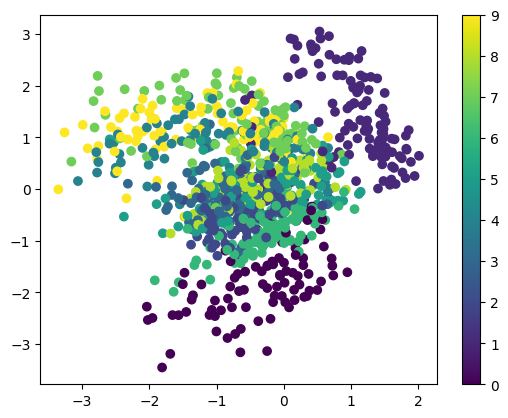

In [39]:
Zdata = np.zeros((10000,latent_dim))
for i in range(10000):
  pick_image = test_images[i,:,:,0]
  data_dict = {input_img:np.expand_dims(pick_image,0)}
  Zdata[i,:] = sess.run(Zsample,feed_dict=data_dict)

#Make plot
idx = np.random.choice(np.arange(len(Zdata)), 1000, replace=False)
Z_plt = Zdata[idx]
label_plt = test_labels[idx]
plt.scatter(Z_plt[:,0],Z_plt[:,1],c=label_plt)
plt.colorbar()

Finally, sample from the prior distribution and decode in order to get a new digit

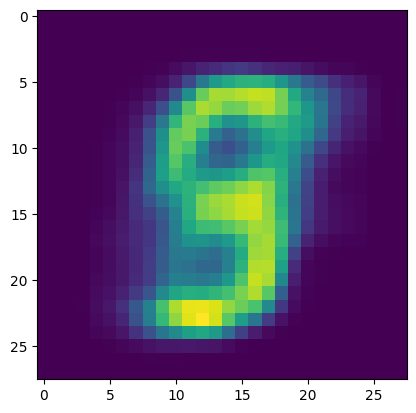

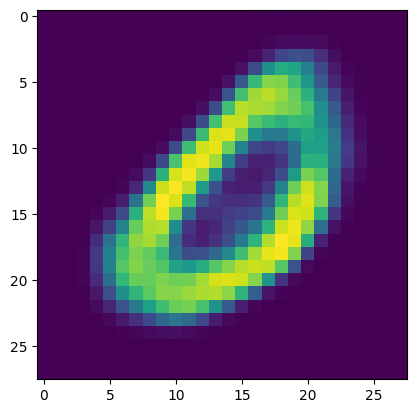

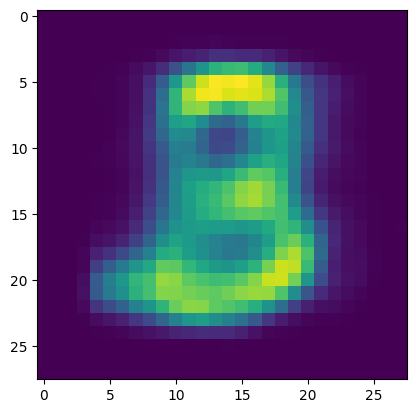

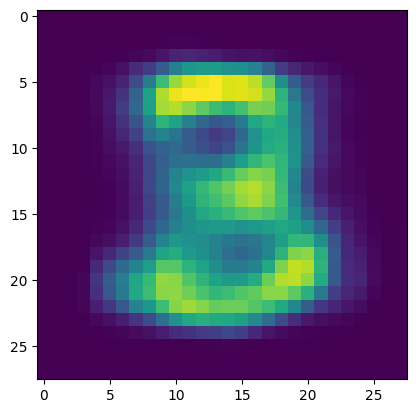

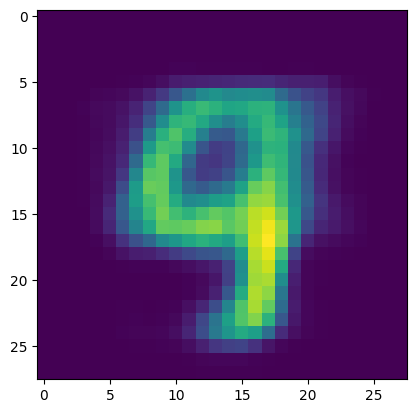

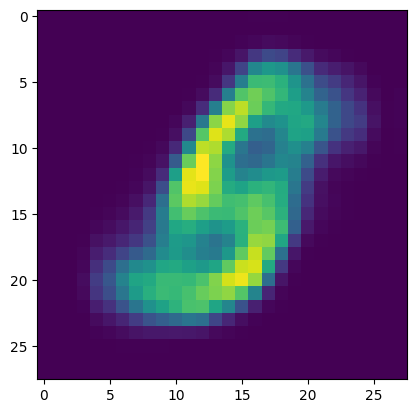

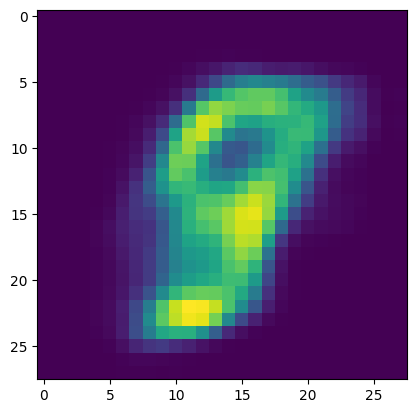

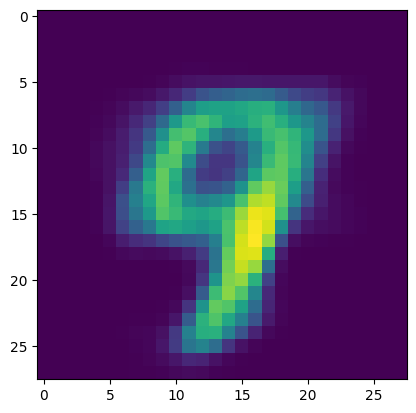

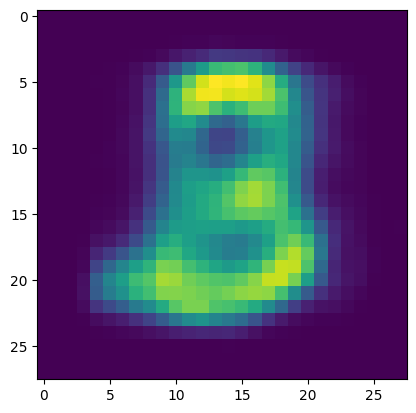

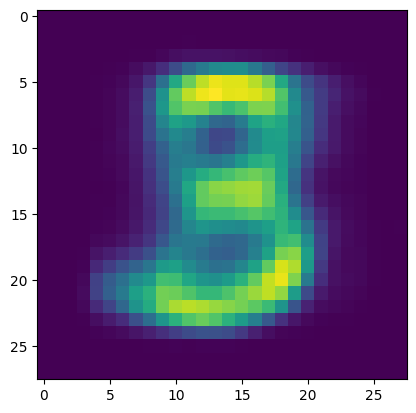

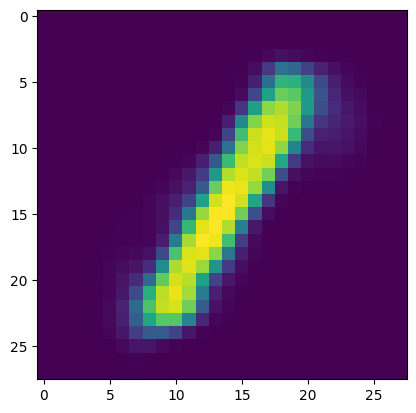

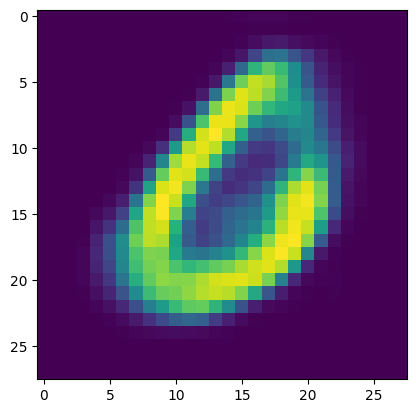

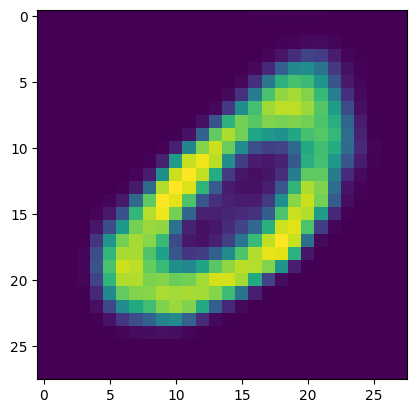

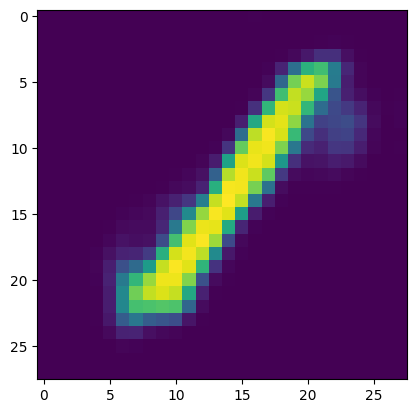

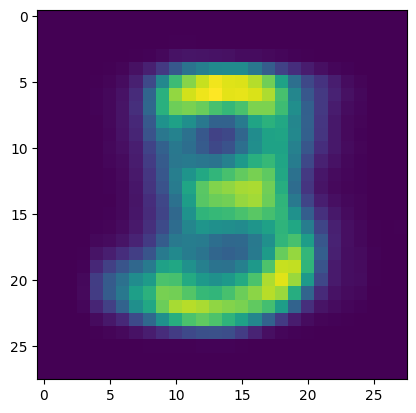

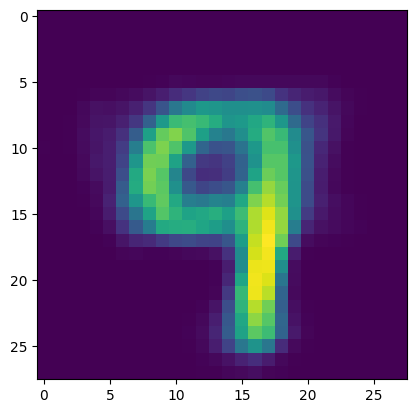

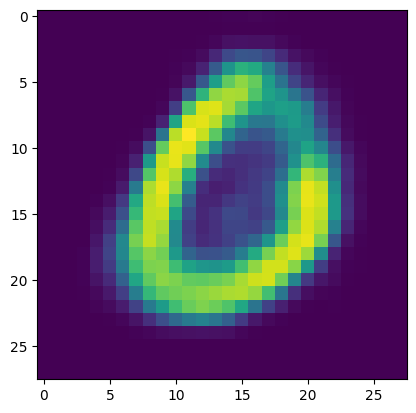

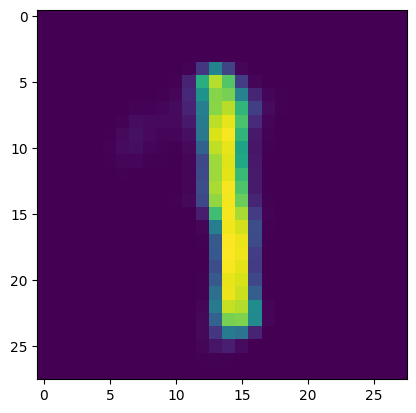

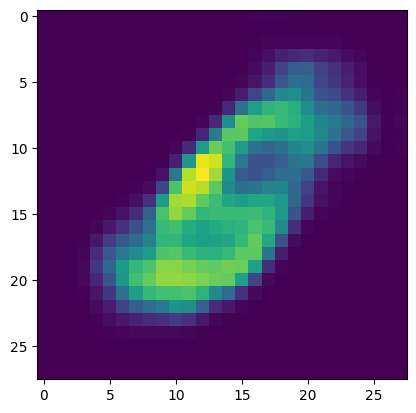

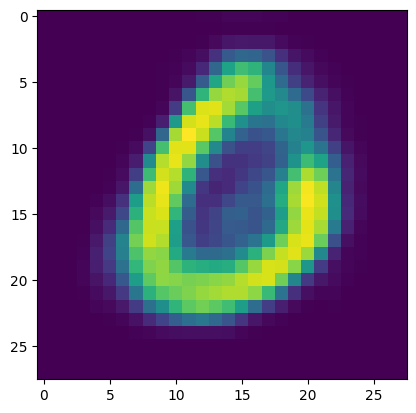

In [40]:
for i in range(20):
  newDigit = sess.run(Znew)
  plt.figure()
  plt.imshow(newDigit[0,:,:,0])
